In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import sklearn.datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import optuna 
from scipy import stats
import lightgbm as lgb
import xgboost as xgb

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

In [40]:
train = pd.read_csv('..\\kaggle_data\\train.csv')
test = pd.read_csv('..\\kaggle_data\\test.csv')
sub = pd.read_csv('..\\kaggle_data\\sample_submission.csv')

#separating training data, all the columns and target columns 
features = [f'cont{x}'for x in range(1,15)]

data = train[features]
X_test = test[features]
target = train['target']
train.head()

,id,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,target
0,1,0.670390,0.811300,0.643968,0.291791,0.284117,0.855953,0.890700,0.285542,0.558245,0.779418,0.921832,0.866772,0.878733,0.305411,7.243043
1,3,0.388053,0.621104,0.686102,0.501149,0.643790,0.449805,0.510824,0.580748,0.418335,0.432632,0.439872,0.434971,0.369957,0.369484,8.203331
2,4,0.834950,0.227436,0.301584,0.293408,0.606839,0.829175,0.506143,0.558771,0.587603,0.823312,0.567007,0.677708,0.882938,0.303047,7.776091
3,5,0.820708,0.160155,0.546887,0.726104,0.282444,0.785108,0.752758,0.823267,0.574466,0.580843,0.769594,0.818143,0.914281,0.279528,6.957716
4,8,0.935278,0.421235,0.303801,0.880214,0.665610,0.830131,0.487113,0.604157,0.874658,0.863427,0.983575,0.900464,0.935918,0.435772,7.951046


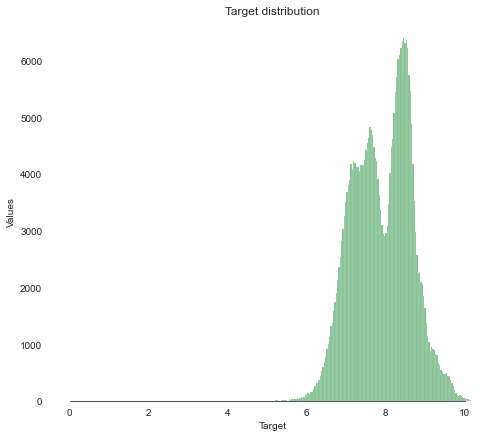

In [41]:
# some part of this code is adapted from this great notebook by Lavanya for beginners
#https://www.kaggle.com/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition
#we will be analyzing the target value first

#setting up the platform
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))

sns.histplot(target, color="g")
ax.xaxis.grid(False)
ax.set(ylabel="Values")
ax.set(xlabel="Target")
ax.set(title="Target distribution")
sns.despine(trim=True, left=True)
plt.show()

<Figure size 432x288 with 0 Axes>

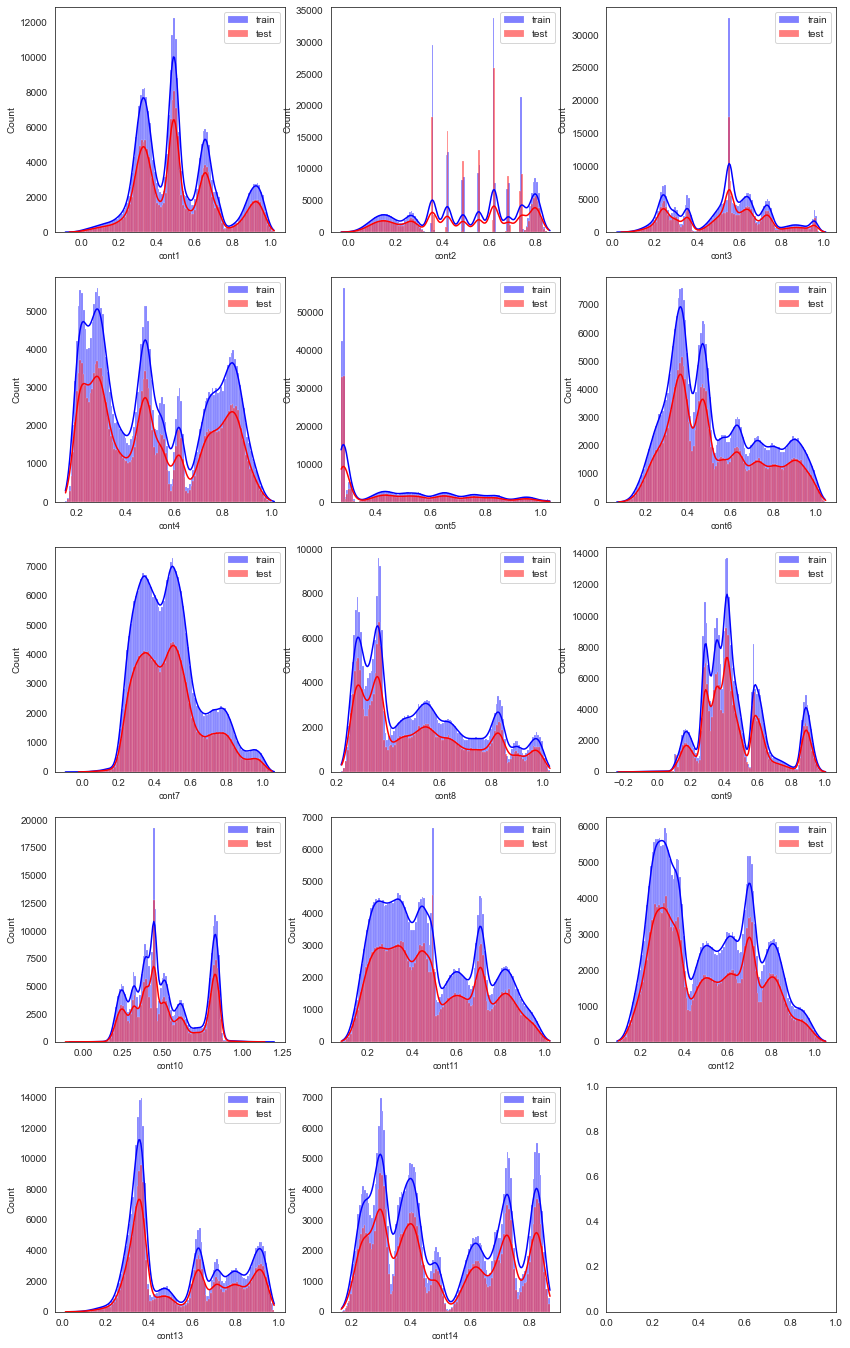

In [42]:
# we will look into the features distribution now, to get insight into the data
i = 1
plt.figure()
fig, ax = plt.subplots(5, 3,figsize=(14, 24))
for feature in features:
    plt.subplot(5, 3,i)
    sns.histplot(train[feature],color="blue", kde=True,bins=120, label='train')
    sns.histplot(test[feature],color="red", kde=True,bins=120, label='test')
    plt.xlabel(feature, fontsize=9); plt.legend()
    i += 1
plt.show()

<AxesSubplot:>

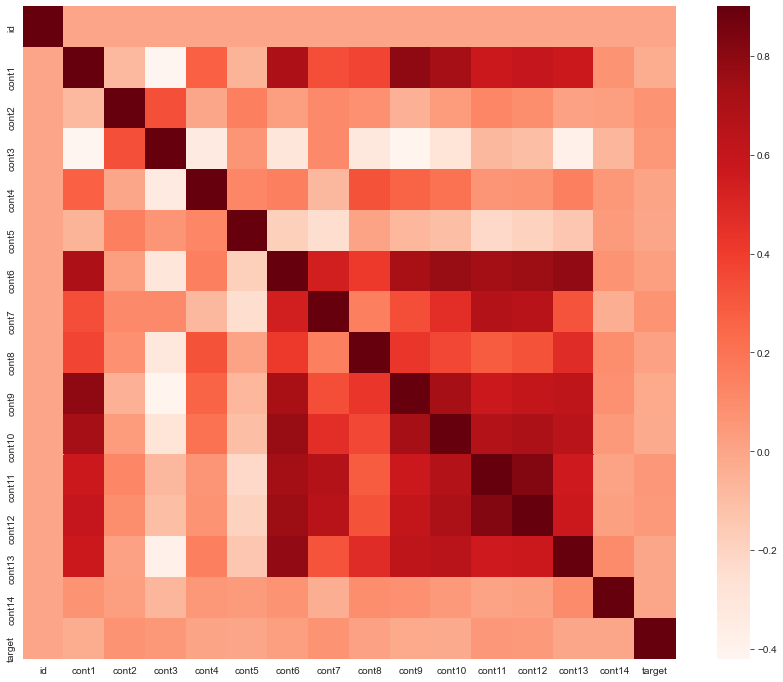

In [43]:
corr = train.corr()
plt.subplots(figsize=(15,12))
sns.heatmap(corr, vmax=0.9, cmap="Reds", square=True)

In [44]:
#normalising the training data
train_data = (data-data.mean())/data.std()
test_data = (X_test - X_test.mean())/X_test.std()

In [45]:
# code and parameters adapted from this great notebook by Hamza, 
#https://www.kaggle.com/hamzaghanmi/xgboost-hyperparameter-tuning-using-optuna

Best_trial = {'lambda': 0.0030282073258141168, 'alpha': 0.01563845128469084, 'colsample_bytree': 0.5,
             'subsample': 0.7,'n_estimators': 4000, 'learning_rate': 0.01,'max_depth': 15,
             'random_state': 2020, 'min_child_weight': 257,'tree_method':'gpu_hist'
             ,'predictor': 'gpu_predictor'}

#you might want to turn on the GPU from the Accelerator or just remove 'tree_method':'gpu_hist'
#from the parameters list
train = train_data
test = test_data
#train on 5 folds cross validation
preds = np.zeros(test.shape[0])
#creating 5 folds
kf = KFold(n_splits=5,random_state=48,shuffle=True)
rmse=[]
n=0
for trn_idx, test_idx in kf.split(train[features],target):
    #separating training and validation data from training columns
    X_tr,X_val=train[features].iloc[trn_idx],train[features].iloc[test_idx]
    #separating training and validation data from target values
    y_tr,y_val=target.iloc[trn_idx],target.iloc[test_idx]
    
    #xgboost regressor with optimized parameters 
    model = xgb.XGBRegressor(**Best_trial)
    model.fit(X_tr,y_tr,eval_set=[(X_val,y_val)],early_stopping_rounds=100,verbose=False)
    
    #predicting on test data provided in separate file(actual test data not validation)
    preds+=model.predict(test[features])/kf.n_splits
    rmse.append(mean_squared_error(y_val, model.predict(X_val), squared=False))
    print(n+1,rmse[n])
    n+=1
print(f"mean RMSE for all the folds is {np.mean(rmse)}")

1 0.6982947256904152
2 0.6953446472499862
3 0.6960804010569537
4 0.6955533655700876
5 0.6958114418140346
mean RMSE for all the folds is 0.6962169162762956


In [46]:
test = pd.read_csv('..\\kaggle_data\\test.csv')[['cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12',
     'cont13', 'cont14']]
test_master = pd.read_csv('..\\kaggle_data\\test.csv')
print(test.head())

preds = model.predict(test)

result = []
x = 0
for index, row in test_master.iterrows():
    result.append([int(row['id']), preds[x]])
    x += 1

from datetime import datetime
dt_string = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")

final_df = pd.DataFrame(result, columns=['id', 'target'])
final_df.to_csv(f'..\\kaggle_data\\{dt_string}_submission.csv', index=False)

final_df.head()

      cont1     cont2     cont3     cont4     cont5     cont6     cont7  \
0  0.353600  0.738780  0.600939  0.293377  0.285691  0.458006  0.620704   
1  0.907222  0.189756  0.215531  0.869915  0.301333  0.528958  0.390351   
2  0.179287  0.355353  0.623972  0.437812  0.282476  0.320826  0.386789   
3  0.359385  0.181049  0.551368  0.206386  0.280763  0.482076  0.506677   
4  0.335791  0.682607  0.676481  0.219465  0.282861  0.581721  0.748639   

      cont8     cont9    cont10    cont11    cont12    cont13    cont14  
0  0.422249  0.369203  0.435727  0.550540  0.699134  0.286864  0.364515  
1  0.521112  0.794779  0.798580  0.446475  0.449037  0.916964  0.513002  
2  0.776422  0.222268  0.229102  0.211913  0.222651  0.327164  0.827941  
3  0.362793  0.379737  0.345686  0.445276  0.518485  0.299028  0.598166  
4  0.350158  0.448915  0.506878  0.817721  0.805895  0.790591  0.249275  


,id,target
0,0,7.894698
1,2,7.957917
2,6,8.005065
3,7,7.933894
4,10,7.862092


In [34]:
#ensemble with notebook submission found at great kernal
#https://www.kaggle.com/somayyehgholami/results-driven-tabular-playground-series-20
sub1 = pd.read_csv("..\\kaggle_data\\18-01-2021_18-21-25_submission.csv")
predictions1 = sub1['target'].tolist()       #will give about 0.69673 with 75,25 ratio 

results = [x*0.72 + y*0.28 for x, y in zip(predictions1, preds)]
# sub['target']=results
# sub.to_csv('submission.csv', index=False)

In [37]:
# parameters from this awesome kernal 
# https://www.kaggle.com/hamditarek/tabular-playground-series-xgboost-lightgbm
Best_trial ={'random_state': 33,'n_estimators':5000,
 'min_data_per_group': 5,
 'boosting_type': 'gbdt',
 'device_type' : 'cpu',
 'num_leaves': 256,
 'max_dept': -1,
 'learning_rate': 0.005,
 'num_iterations': 5000,
 'subsample_for_bin': 200000,
 'lambda_l1': 1.074622455507616e-05,
 'lambda_l2': 2.0521330798729704e-06,
 'n_jobs': -1,
 'cat_smooth': 1.0,
 'silent': True,
 'importance_type': 'split',
 'metric': 'rmse',
 'feature_pre_filter': False,
 'bagging_fraction': 0.8206341150202605,
 'min_data_in_leaf': 100,
 'min_sum_hessian_in_leaf': 0.001,
 'bagging_freq': 6,
 'feature_fraction': 0.5,
 'min_gain_to_split': 0.0,
 'min_child_samples': 20}

In [38]:
preds = np.zeros(test.shape[0])
#creating 5 folds
kf = KFold(n_splits=5,random_state=48,shuffle=True)
rmse=[]
n=0
for trn_idx, test_idx in kf.split(train[features],target):
    #separating training and validation data from training columns
    X_tr,X_val=train[features].iloc[trn_idx],train[features].iloc[test_idx]
    #separating training and validation data from target values
    y_tr,y_val=target.iloc[trn_idx],target.iloc[test_idx]
    
    #xgboost regressor with optimized parameters 
    model = lgb.LGBMRegressor(**Best_trial)
    model.fit(X_tr,y_tr,eval_set=[(X_val,y_val)],early_stopping_rounds=50,verbose=False)
    
    #predicting on test data provided in separate file(actual test data, not the validation)
    preds+=model.predict(test[features])/kf.n_splits
    rmse.append(mean_squared_error(y_val, model.predict(X_val), squared=False))
    print(n+1,rmse[n])
    n+=1
print(f"mean RMSE for all the folds is {np.mean(rmse)}")

1 0.6943158423099625
[LightGBM] [Warning] Unknown parameter: max_dept
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Warning] lambda_l1 is set=1.074622455507616e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.074622455507616e-05
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.001, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] bagging_fraction is set=0.8206341150202605, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8206341150202605
[LightGBM] [Warning] lambda_l2 is set=2.0521330798729704e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0521330

c:\users\ryans\source\repos\venvs\python375\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


2 0.6948828380550789
[LightGBM] [Warning] Unknown parameter: max_dept
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Warning] lambda_l1 is set=1.074622455507616e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.074622455507616e-05
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.001, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] bagging_fraction is set=0.8206341150202605, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8206341150202605
[LightGBM] [Warning] lambda_l2 is set=2.0521330798729704e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0521330

c:\users\ryans\source\repos\venvs\python375\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


3 0.6934673002869971
[LightGBM] [Warning] Unknown parameter: max_dept
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Warning] lambda_l1 is set=1.074622455507616e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.074622455507616e-05
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.001, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] bagging_fraction is set=0.8206341150202605, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8206341150202605
[LightGBM] [Warning] lambda_l2 is set=2.0521330798729704e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0521330

c:\users\ryans\source\repos\venvs\python375\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


4 0.6922432483161652
[LightGBM] [Warning] Unknown parameter: max_dept
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Warning] lambda_l1 is set=1.074622455507616e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.074622455507616e-05
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.001, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] bagging_fraction is set=0.8206341150202605, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8206341150202605
[LightGBM] [Warning] lambda_l2 is set=2.0521330798729704e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0521330

c:\users\ryans\source\repos\venvs\python375\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


5 0.6945014567310466
mean RMSE for all the folds is 0.69388213713985


In [39]:
#ensembling old results with light GBM model

sub1 = pd.read_csv('..\\kaggle_data\\20-01-2021_17-48-01_submission.csv')
fin_res  = sub1['target'].tolist() 
final_results = [x*0.46 + y*0.54 for x, y in zip(fin_res, preds)]
sub['target']=fin_res



from datetime import datetime
dt_string = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")
sub.to_csv(f'..\\kaggle_data\\{dt_string}_submission.csv', index=False)

sub.head()


,id,target
0,0,7.927404
1,2,8.024018
2,6,7.941860
3,7,7.962679
4,10,7.892688
